# DisCoCirc model

In this tutorial, we train a pure quantum {term}`PennyLane` {term}`model` to solve a toy problem: classifying whether a given triplet of sentences is about cooking or computing. As we are dealing with text and not just individual sentences, we utilise the *Distributional Compositional Circuit-shaped* model {cite:p}`coecke_2021a` to capture how the sentences of a text interact to produce the meaning of that text.

We use a {py:class}`.Sim4Ansatz` to convert {term}`string diagrams <string diagram>` into {term}`quantum circuits <quantum circuit>`. When passing these circuits to the {py:class}`PennyLaneModel`, they are automatically converted into {term}`PennyLane` circuits.

{download}`⬇️ Download code <../_code/discocirc-mc-task.ipynb>`

## Preparation

We start by specifying some training hyperparameters and importing NumPy and PyTorch.

In [1]:
BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.01
SEED = 42

In [2]:
import random
import numpy as np
import torch

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Input data

Let's read the data and print some example sentences.

In [4]:
# Read newly generated data
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1. - t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [6]:
train_labels, train_data = read_data('../examples/datasets/discocirc_mc_train_data.txt')
dev_labels, dev_data = read_data('../examples/datasets/discocirc_mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/discocirc_mc_test_data.txt')

In [7]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [8]:
train_data[:5]

['skillful man prepares sauce . skillful man cooks sauce . person cooks meal .',
 'woman prepares tasty meal . person cooks dinner . she bakes tasty meal .',
 'skillful man bakes meal . man bakes tasty sauce . skillful man cooks sauce .',
 'woman cooks tasty dinner . skillful person cooks sauce . skillful person bakes sauce .',
 'skillful woman prepares meal . woman cooks tasty dinner . person cooks sauce .']

Targets are represented as 2-dimensional arrays:

In [9]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

### Creating and parameterising diagrams

The first step is to convert the sentence triplets into {term}`string diagrams <string diagram>`. For that, we use the experimental {py:class}`DisCoCircReader` class. Also, to facilitate convertion to quantum circuits, we pass `sandwich=True` in the {py:meth}`.text2circuit` call.

In [10]:
from lambeq.experimental.discocirc import DisCoCircReader


reader = DisCoCircReader()

raw_train_diags = [reader.text2circuit(t, sandwich=True) for t in train_data]
raw_dev_diags = [reader.text2circuit(t, sandwich=True) for t in dev_data]
raw_test_diags = [reader.text2circuit(t, sandwich=True) for t in test_data]

/Users/neil.ortega/.miniconda/dcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/neil.ortega/.miniconda/dcc/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We can visualise thes diagrams using {py:meth}`~lambeq.backend.grammar.Diagram.draw`.

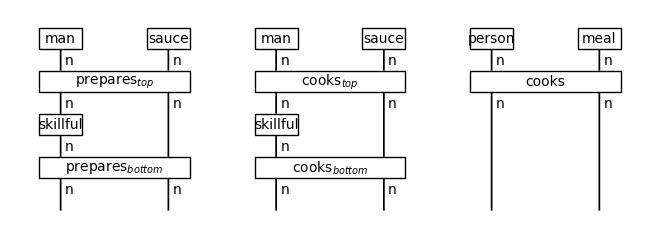

In [11]:
raw_train_diags[0].draw()

### Combination box

As one can see from the example diagram above, we need a means to combine the output wires of the diagram and just output a single wire at the end. This is easily done by adding a {py:class}`.grammar.Box` whose domain is the current diagram output and whose codomain is a single wire which we give the type `T` for `'text'`.

In [12]:
from lambeq import AtomicType
from lambeq.backend.grammar import Box, Ty


# Declare the types we will use
N = AtomicType.NOUN
T = Ty('t')     # 't' for 'text'

# Add fan-in box as last layer for each diagram
def add_fan_in_box(diag):
    fan_in_box = Box(name='fan in',
                     dom=diag.cod,
                     cod=T)
    diag >>= fan_in_box
    return diag

train_diags = [add_fan_in_box(d) for d in raw_train_diags]
dev_diags = [add_fan_in_box(d) for d in raw_dev_diags]
test_diags = [add_fan_in_box(d) for d in raw_test_diags]

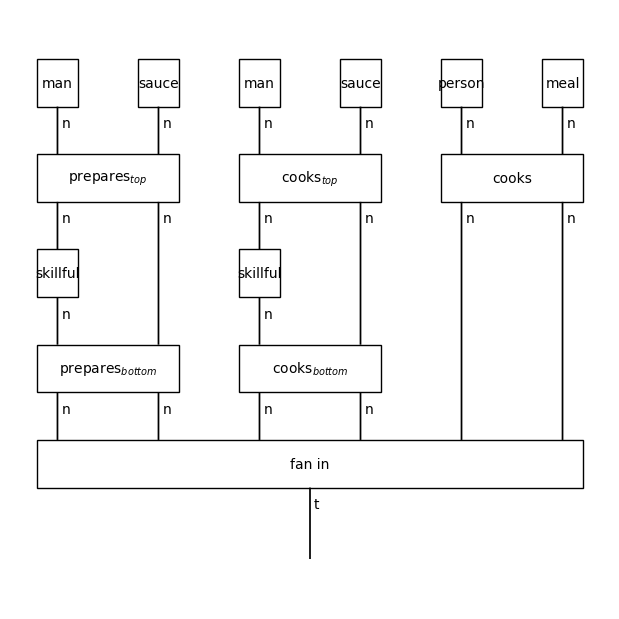

In [13]:
train_diags[0].draw(figsize=(6, 6))

There will be several versions of this 'fan in' box - they only vary on the number of noun wires in its domain.

### Create circuits

In order to run the experiments on a quantum computer, we apply a quantum {term}`ansatz <ansatz (plural: ansätze)>` to the string diagrams. For this experiment, we will use a {py:class}`.Sim4Ansatz`, where noun wires (`n`) and text wires (`t`) are represented by one-qubit systems.

In [14]:
from lambeq import Sim4Ansatz


ansatz = Sim4Ansatz({N: 1, T: 1}, n_layers=3)

train_circs = [ansatz(diag) for diag in train_diags]
dev_circs = [ansatz(diag) for diag in dev_diags]
test_circs = [ansatz(diag) for diag in test_diags]

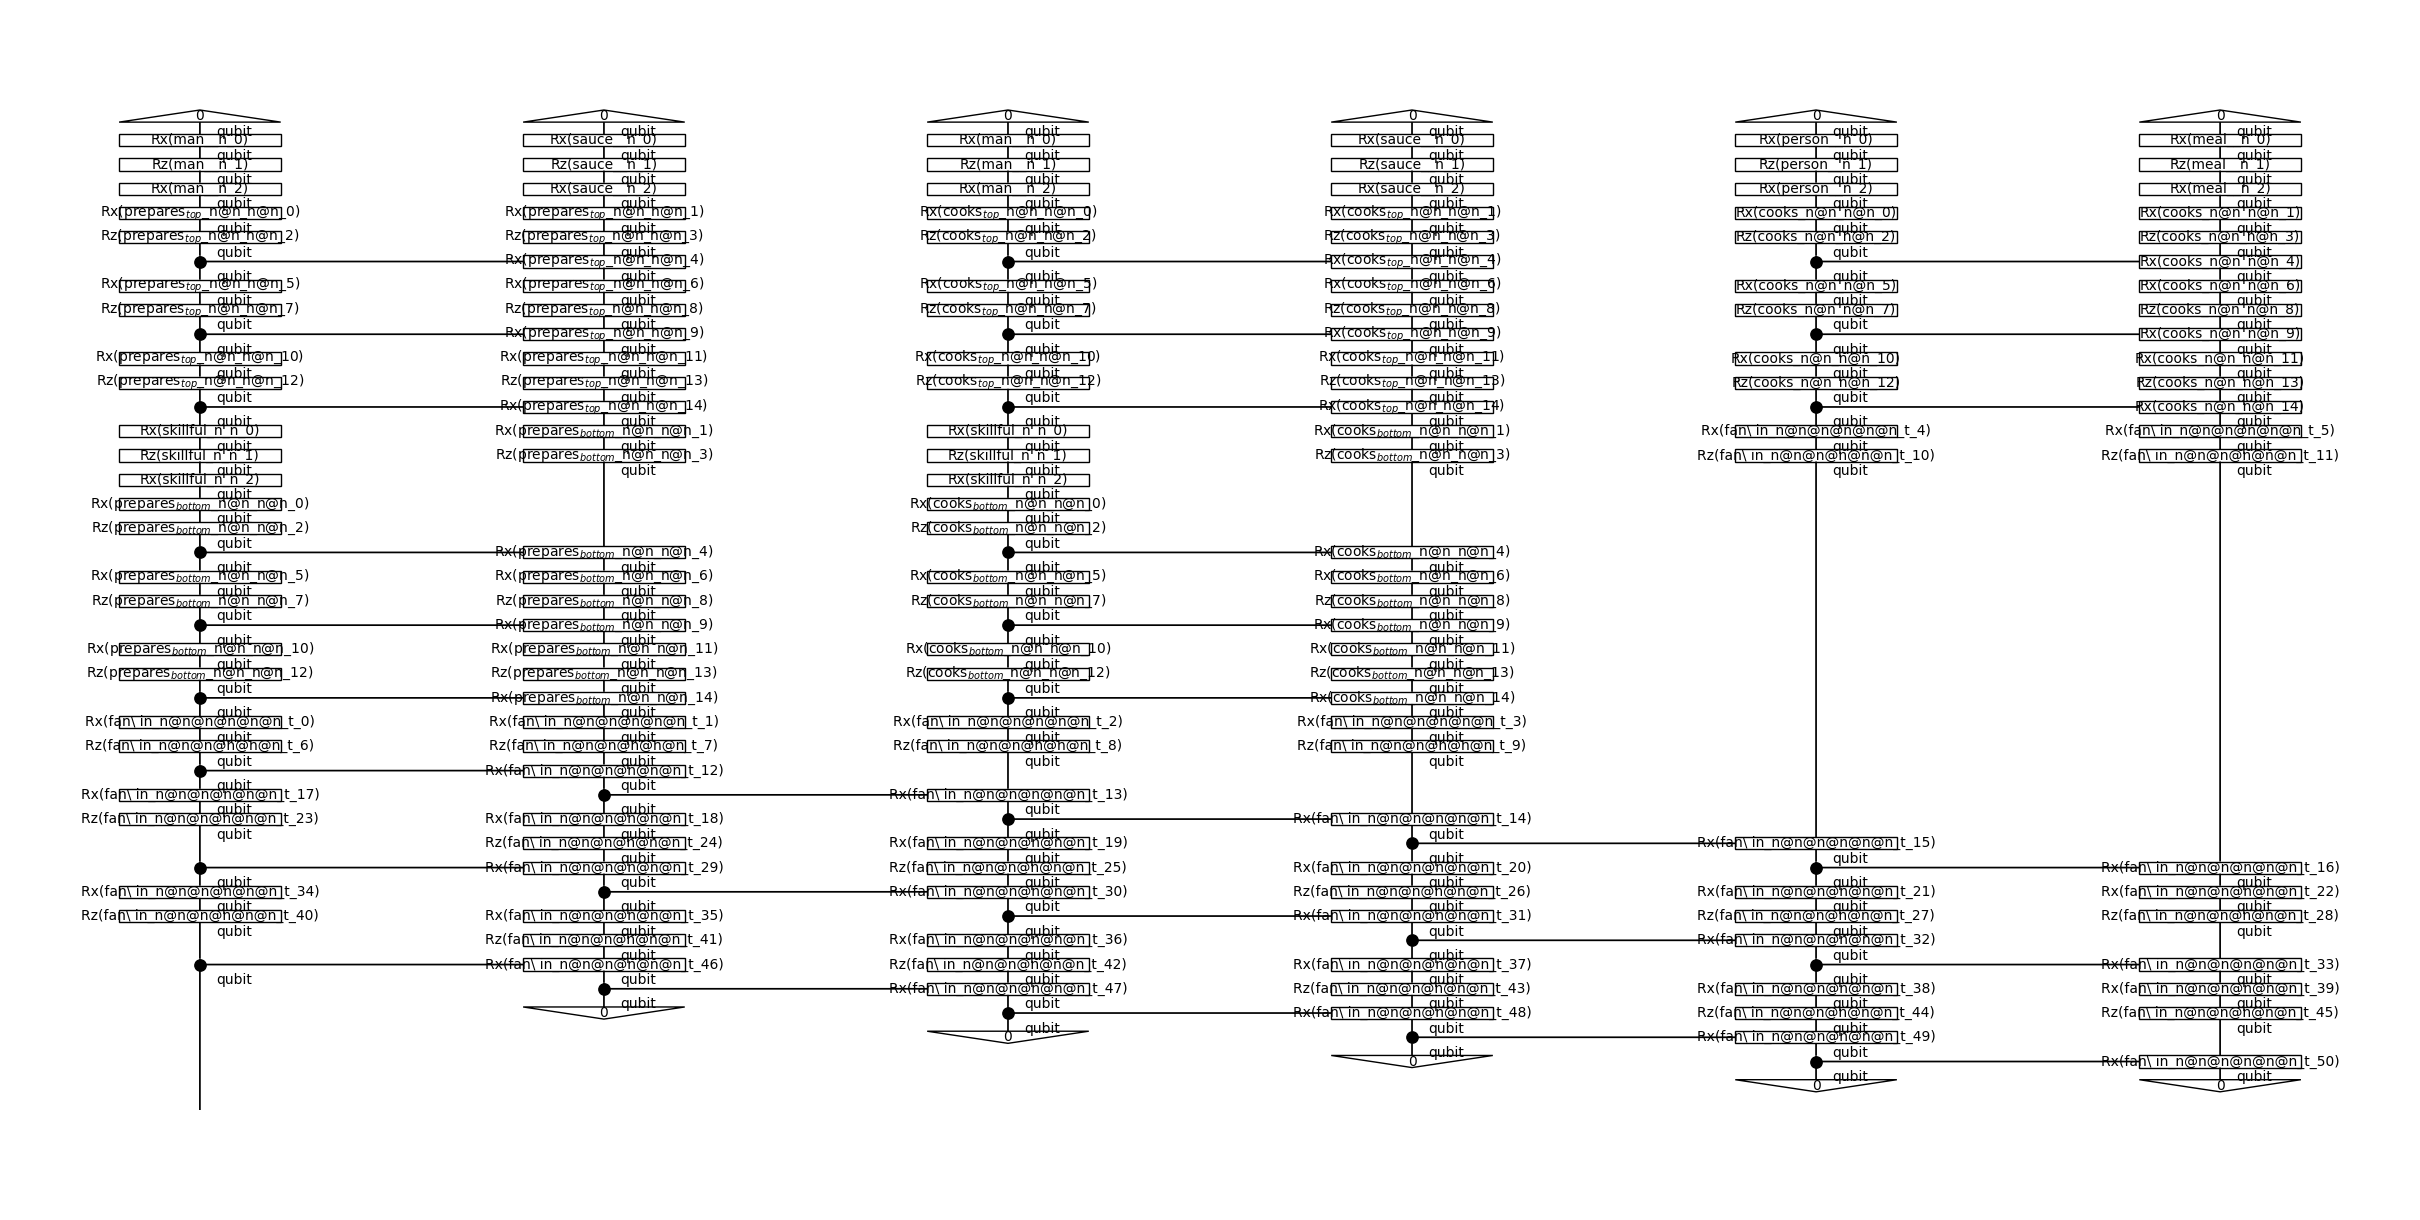

In [15]:
train_circs[0].draw(figsize=(24, 12))

## Training

### Instantiate model

We instantiate a {py:class}`.PennyLaneModel`, by passing all diagrams to the class method {py:meth}`.PennyLaneModel.from_diagrams`.

We also set `probabilities=True` so that the model outputs probabilities, rather than quantum states, which follows the behaviour of real quantum computers.

Furthermore, we set `normalize=True` so that the output probabilities sum to one. This helps to prevent passing very small values to any following layers in a hybrid model.

In [16]:
from lambeq import PennyLaneModel


all_circs = train_circs + dev_circs + test_circs

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circs,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running this model on a real quantum computer takes a significant amount of time as the circuits must be sent to the backend and queued, so in this tutorial we will use `model`, which uses the default {term}`PennyLane` simulator, 'default.qubit'.

### Create datasets

To facilitate data shuffling and batching, `lambeq` provides a native {py:class}`.Dataset` class. Shuffling is enabled by default, and if not specified, the batch size is set to the length of the dataset.

In [16]:
from lambeq import Dataset


train_dataset = Dataset(train_circs,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circs,
                      dev_labels,
                      shuffle=False)

Training can either by done using the {py:class}`.PytorchTrainer`, or by using native PyTorch. We give examples of both in the following section.

### Define loss and evaluation metric

When using {py:class}`.PytorchTrainer` we first define our evaluation metrics and loss function, which in this case will be the accuracy and the mean-squared error, respectively.

In [17]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)


def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, torch.Tensor(y)
    )

### Initialise trainer

As {term}`PennyLane` is compatible with PyTorch autograd, {py:class}`.PytorchTrainer` can automatically use many of the PyTorch optimizers, such as Adam to train our model.

In [18]:
from lambeq import PytorchTrainer


trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Train

We can now pass the datasets to the {py:meth}`~lambeq.Trainer.fit` method of the trainer to start the training.

In [19]:
trainer.fit(train_dataset, dev_dataset)

Epoch 1:   train/loss: 0.9053   valid/loss: 1.0019   train/time: 2m33s   valid/time: 47.31s   train/acc: 0.5950   valid/acc: 0.4500
Epoch 2:   train/loss: 1.0679   valid/loss: 0.7821   train/time: 2m48s   valid/time: 54.13s   train/acc: 0.6000   valid/acc: 0.5333
Epoch 3:   train/loss: 0.6426   valid/loss: 0.5270   train/time: 2m42s   valid/time: 48.36s   train/acc: 0.6650   valid/acc: 0.6833
Epoch 4:   train/loss: 1.3289   valid/loss: 0.6606   train/time: 2m38s   valid/time: 46.09s   train/acc: 0.7100   valid/acc: 0.6333
Epoch 5:   train/loss: 1.0372   valid/loss: 0.6191   train/time: 2m38s   valid/time: 48.32s   train/acc: 0.7300   valid/acc: 0.6500
Epoch 6:   train/loss: 0.2213   valid/loss: 0.6458   train/time: 2m48s   valid/time: 49.66s   train/acc: 0.7600   valid/acc: 0.6333
Epoch 7:   train/loss: 0.2475   valid/loss: 0.4967   train/time: 2m43s   valid/time: 51.66s   train/acc: 0.8500   valid/acc: 0.8000
Epoch 8:   train/loss: 0.3394   valid/loss: 0.8590   train/time: 2m48s   val

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.95


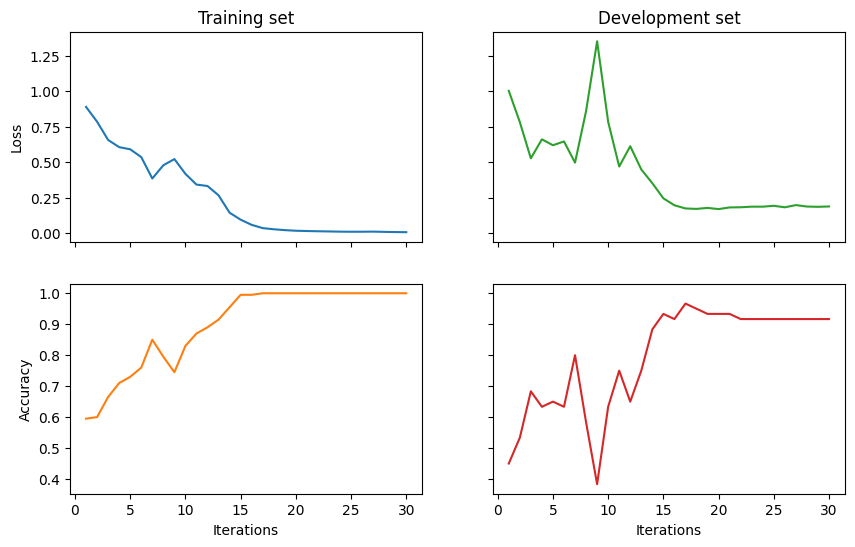

In [20]:
import matplotlib.pyplot as plt


fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circs)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

## Appendix

### Creating the sentence triplets

The original dataset only has one sentence and a label for each datapoint. We've create the following function to be able to create sentence n-tuples (`n=3` for triplets), making sure that all three sentences are of the same label, i.e. either all are about cooking or all are about computing, and that the n-tuples are unique up to ordering of the sentences in the n-tuple.

To make the diagrams more interesting, we randomly did pronoun substitution when possible, e.g. when the first sentence begins with `'man ...'` and the second and/or third sentence also contains `'man ...'`, then we substitute it with `'he'` randomly.

In [ ]:
from itertools import combinations
from pathlib import Path


DATASET_DIR = Path('../examples/datasets/')

In [ ]:
train_dataset_fp = DATASET_DIR / 'mc_train_data.txt'
dev_dataset_fp = DATASET_DIR / 'mc_dev_data.txt'
test_dataset_fp = DATASET_DIR / 'mc_test_data.txt'

In [ ]:
def create_dataset(filename,
                   sents_per_text: int = 3,
                   n_texts: int = 100,
                   substitute_pronouns: bool = False):
    datapoint = []
    with open(filename) as f:
        for line in f:
            text = line[1:].strip()
            # For some reason, 'debugs program' doesn't parse
            # 'debugs' as a verb, but 'fixes' does.
            text = text.replace('debugs', 'fixes')
            datapoint.append((
                int(line[0]), text
            ))
    
    # Split by label
    food_split = [t for t in datapoint if t[0]]
    it_split = [t for t in datapoint if not t[0]]

    def _generate_new_datapoints(split, sample_size):
        sample = random.sample(
            list(combinations(split, sents_per_text)),
            sample_size,
        )
        print(f'{sample[0] = }')
        
        # Merge sentences
        sample_merged = []
        for s in sample:
            s = list(s)
            if substitute_pronouns:
                # Do naive substitution
                if s[0][1].startswith('skillful woman'):
                    for i in [1, 2]:
                        s[i] = (s[i][0],
                                s[i][1].replace('skillful woman',
                                                random.choice(['she', 'skillful woman', 'woman'])))
                elif s[0][1].startswith('skillful man'):
                    for i in [1, 2]:
                        s[i] = (s[i][0],
                                s[i][1].replace('skillful man',
                                                random.choice(['he', 'skillful man', 'man'])))
                elif s[0][1].startswith('skillful person'):
                    for i in [1, 2]:
                        s[i] = (s[i][0],
                                s[i][1].replace('skillful person',
                                                random.choice(['he', 'she', 'person', 'skillful person'])))
                elif s[0][1].startswith('woman'):
                    for i in [1, 2]:
                        if s[i][1].startswith('woman'):
                            s[i] = (s[i][0],
                                    s[i][1].replace('woman',
                                                    random.choice(['she', 'woman'])))
                elif s[0][1].startswith('man'):
                    for i in [1, 2]:
                        if s[i][1].startswith('man'):
                            s[i] = (s[i][0],
                                    s[i][1].replace('man',
                                                    random.choice(['he', 'man'])))
                elif s[0][1].startswith('person'):
                    for i in [1, 2]:
                        if s[i][1].startswith('person'):
                            s[i] = (s[i][0],
                                    s[i][1].replace('person',
                                                    random.choice(['he', 'she', 'person'])))
            sample_merged.append((
                s[0][0],
                ' '.join(
                    [ss[1] for ss in s]
                ),
            ))
        print(f'{sample_merged[0] = }')

        return sample_merged
    
    food_text = _generate_new_datapoints(food_split, n_texts // 2)
    it_text = _generate_new_datapoints(it_split, n_texts // 2)

    return food_text + it_text

In [24]:
train_dataset = create_dataset(train_dataset_fp, n_texts=200, substitute_pronouns=True)
dev_dataset = create_dataset(dev_dataset_fp, n_texts=60, substitute_pronouns=True)
test_dataset = create_dataset(test_dataset_fp, n_texts=60, substitute_pronouns=True)

sample[0] = ((1, 'man prepares meal .'), (1, 'woman cooks tasty dinner .'), (1, 'person bakes dinner .'))
sample_merged[0] = (1, 'man prepares meal . woman cooks tasty dinner . person bakes dinner .')
sample[0] = ((0, 'person runs useful application .'), (0, 'woman runs useful application .'), (0, 'woman runs program .'))
sample_merged[0] = (0, 'person runs useful application . woman runs useful application . woman runs program .')
sample[0] = ((1, 'man bakes sauce .'), (1, 'skillful person prepares sauce .'), (1, 'woman bakes tasty dinner .'))
sample_merged[0] = (1, 'man bakes sauce . skillful person prepares sauce . woman bakes tasty dinner .')
sample[0] = ((0, 'skillful person prepares application .'), (0, 'man runs program .'), (0, 'person prepares useful software .'))
sample_merged[0] = (0, 'skillful person prepares application . man runs program . person prepares useful software .')
sample[0] = ((1, 'skillful man prepares dinner .'), (1, 'skillful woman bakes dinner .'), (1, 'man

In [ ]:
# Write created datasets to disk
for k, v in {'train': train_dataset,
             'dev': dev_dataset,
             'test': test_dataset}.items():
    with open(DATASET_DIR / f'discocirc_mc_{k}_data.txt', 'w') as f:
        f.write('\n'.join([f'{label} {text}' for (label, text) in v]))

Lastly, the observation below is the reason for substituting `'fixes'` to `'debug'` when creating the triplet dataset.

/Users/neil.ortega/.miniconda/dcc/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint

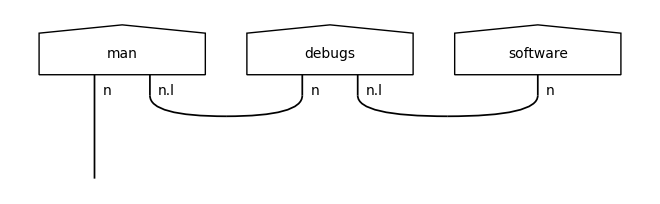

In [26]:
from lambeq import BobcatParser

bc_reader = BobcatParser()
bc_reader.sentence2diagram('man debugs software').draw()

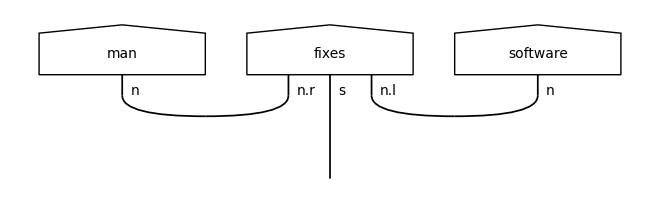

In [27]:
bc_reader.sentence2diagram('man fixes software').draw()